In [17]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas
import xarray
import h5py

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting

In [18]:
tbl_file = 's3://llc/Tables/test_modis2012.parquet'
llc_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://llc/Tables/test_modis2012.parquet


In [19]:
llc_table.head()

,modis_lat,modis_lon,modis_col,modis_datetime,modis_LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,field_size,pp_type,pp_idx,lat,lon,row,col,datetime,filename,LL
0,-52.410507,-42.126858,1028,2012-01-01 04:10:00,-147.370605,64,0.049805,4.126851,3.401999,6.411,...,64,0,296266,-52.406319,-42.135418,4687,17049,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,127.225403
1,-52.194720,-42.787216,997,2012-01-01 04:10:00,-248.946106,48,0.043213,5.315916,3.464000,6.544,...,64,0,592057,-52.188812,-42.781250,4705,17018,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,53.644531
2,-52.031720,-43.191420,976,2012-01-01 04:10:00,-264.156342,33,0.049500,5.914161,3.557000,6.852,...,64,0,214472,-52.031147,-43.197918,4718,16998,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,161.347656
3,-51.908875,-42.702328,997,2012-01-01 04:10:00,-228.816925,16,0.018188,5.859090,3.442000,6.709,...,64,0,467098,-51.909538,-42.697918,4728,17022,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,172.184753
4,-51.865665,-43.186947,974,2012-01-01 04:10:00,-260.829315,16,0.048279,6.130058,5.386000,6.852,...,64,0,415175,-51.860813,-43.177082,4732,16999,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,156.553528


In [20]:
llc_table.iloc[0].filename

's3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_00.nc'

In [21]:
print('LLC granule: {}'.format(llc_table.iloc[0].filename))

LLC granule: s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_00.nc


In [22]:
print('PreProc file: {}'.format(llc_table.iloc[0].pp_file))

PreProc file: s3://llc/PreProc/LLC_modis2012_test_preproc.h5


In [23]:
llc_table.iloc[0]

modis_lat                                                  -52.410507
modis_lon                                                  -42.126858
modis_col                                                        1028
modis_datetime                                    2012-01-01 04:10:00
modis_LL                                                  -147.370605
modis_row                                                          64
clear_fraction                                               0.049805
mean_temperature                                             4.126851
Tmin                                                         3.401999
Tmax                                                            6.411
T90                                                              5.46
T10                                                             3.562
modis_filename                   AQUA_MODIS.20120101T041007.L2.SST.nc
UID                                                132537589513787314
pp_file             

# Normal Noise distribution

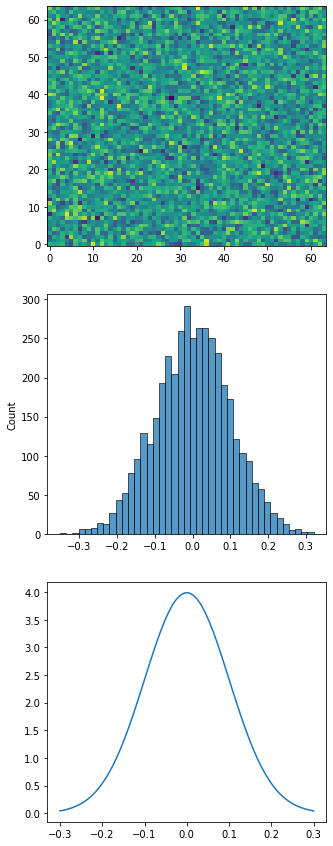

In [36]:
fig, axes = plt.subplots(3, 1, figsize = (5, 15))

mu = 0
sigma = 0.1

c = np.random.normal(mu, sigma, (64,64))
x = np.arange(0, 64)
y = np.arange(0, 64)

X,Y = np.meshgrid(x, y)

axes[0].pcolormesh(X,Y,c,shading='auto')
g = sns.histplot(c.flatten(), legend = False, ax = axes[1])

x1 = np.linspace(mu- 3*sigma, mu + 3*sigma, 64)
axes[2].plot(x1, stats.norm.pdf(x1, mu, sigma))

plt.show()

In [37]:
print('Mean is: {} and std dev is: {}'.format(np.mean(c), np.std(c)))

Mean is: 0.0006912655159640983 and std dev is: 0.09894689847090346


# Image comparison

#### No noise

In [24]:
cd

/home/jovyan


In [25]:
pwd

'/home/jovyan'

In [35]:
li = np.random.randint(0, 635295, 5)

In [36]:
for i, elem in enumerate(li):
    print(i, elem)

0 368198
1 143829
2 581794
3 434123
4 53826


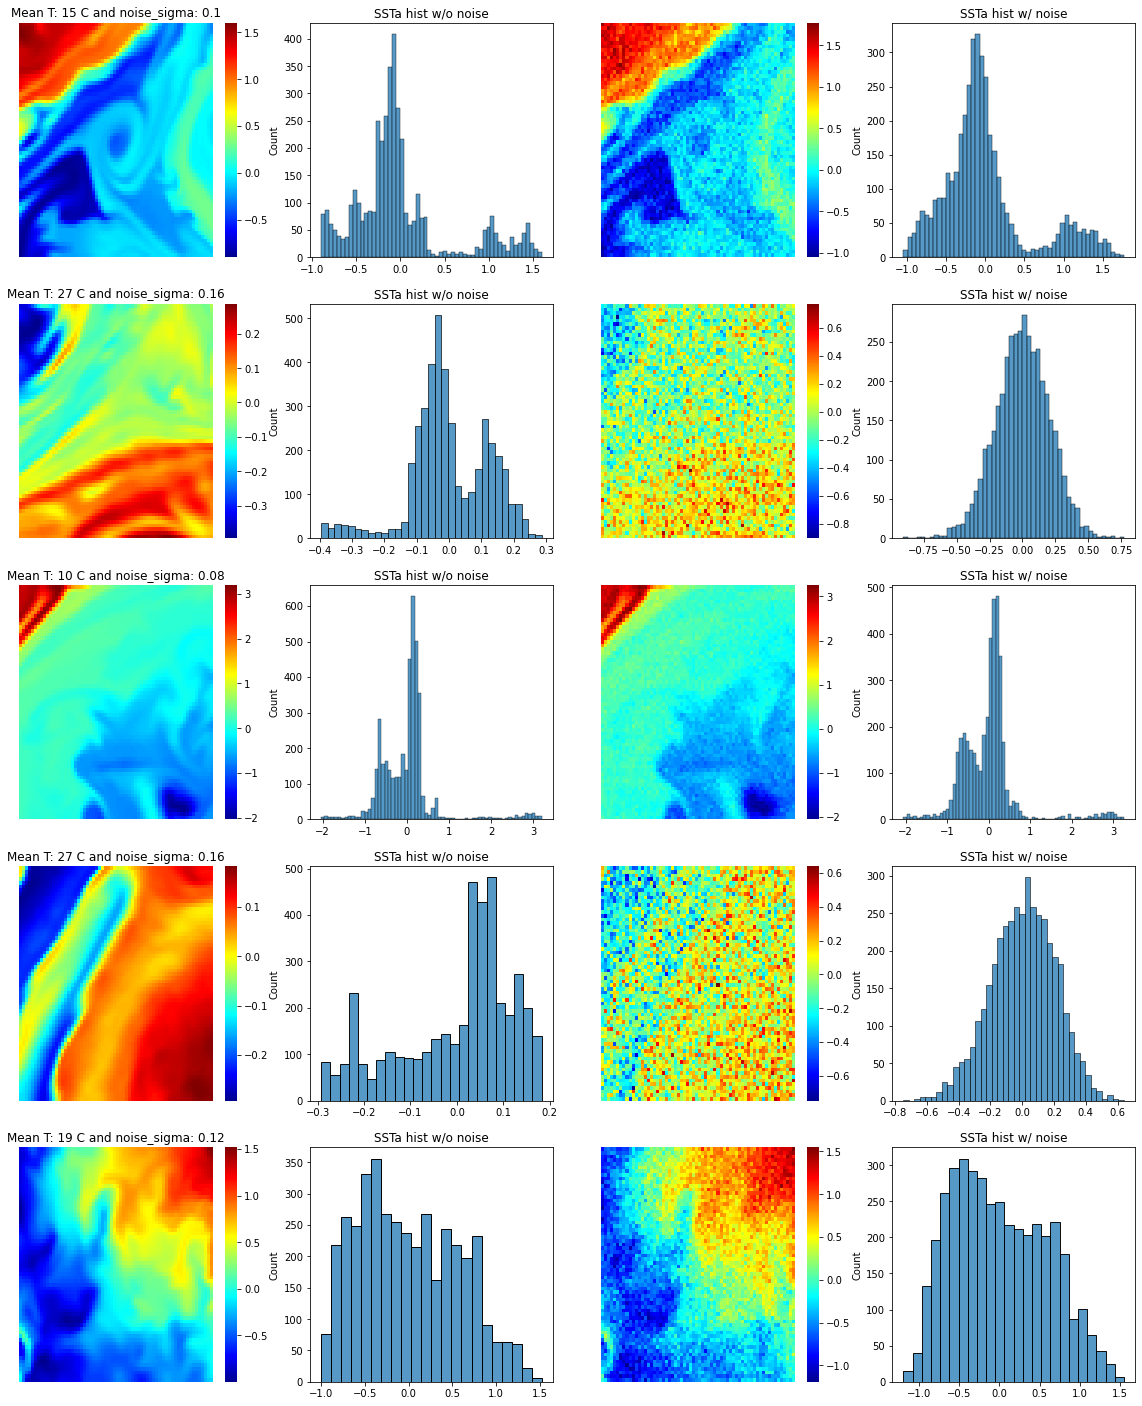

In [37]:
fig, axes = plt.subplots(5, 4, figsize = (20,25) )

_, cm = ulmo_plotting.load_palette()

with h5py.File('/home/jovyan/ulmo/ulmo/notebooks/LLC_modis2012_test_preproc.h5', 'r') as pp_hf:
    
    mean_T = pp_hf['valid_metadata'][:,7]
    
    for i, elem in enumerate(li):

        ax = axes[i][0]
        img = pp_hf['valid'][elem, 0, ...]
        g = sns.heatmap(np.flipud(img), xticklabels = [], yticklabels = [], cmap=cm, ax = ax)
        tmp = float( mean_T[elem].decode() )
        g.set_title('Mean T: {} C and noise_sigma: {}'.format(round(tmp), round(0.031 + 0.0048*tmp, 2)))
        
        ax = axes[i][1]
        
        h = sns.histplot(img.flatten(), stat = 'count', ax =ax, legend = False)
        h.set_title('SSTa hist w/o noise')
        
with h5py.File('/home/jovyan/ulmo/ulmo/notebooks/LLC_modis2012_test_SST_noise_preproc.h5', 'r') as pp_hf:
    
    for i, elem in enumerate(li):

        ax = axes[i][2]
        img = pp_hf['valid'][elem, 0, ...]
        g = sns.heatmap(np.flipud(img), xticklabels = [], yticklabels = [], cmap=cm, ax = ax)
        
        ax = axes[i][3]
        
        h = sns.histplot(img.flatten(), stat = 'count', ax = ax, legend = False)
        h.set_title('SSTa hist w/ noise')
    

plt.show()

In [40]:
num = li[0]
num

368198

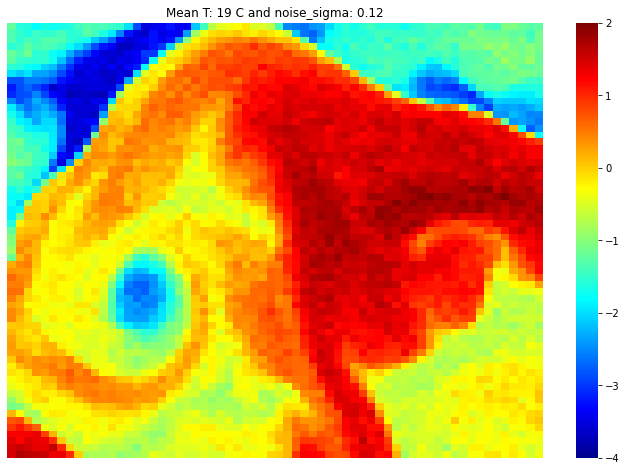

In [59]:
fig, ax = plt.subplots( figsize = (12,8) )

_, cm = ulmo_plotting.load_palette()

with h5py.File('/home/jovyan/ulmo/ulmo/notebooks/LLC_modis2012_test_SST_noise_preproc.h5', 'r') as pp_hf:
    mean_T = pp_hf['valid_metadata'][:,7]
    
    img = pp_hf['valid'][19534, 0, ...]
    g = sns.heatmap(np.flipud(img), xticklabels = [], yticklabels = [], vmin = 2, vmax=-4, cmap=cm, ax = ax)
    g.set_title('Mean T: {} C and noise_sigma: {}'.format(round(tmp), round(0.031 + 0.0048*tmp, 2)))


In [43]:
with h5py.File('LLC_modis2012_test_preproc.h5', 'r') as pp_hf:
    
    mean_T = pp_hf['valid_metadata'][:,7]

In [44]:
float(mean_T[1].decode())

17.87476348876953

# Homogeneous cutout

In [45]:
img0 = np.zeros( shape=(64, 64) )
tmp = 20 
std = 0.031 + 0.0048*tmp

noise = np.random.normal(0., std, (64,64))

img1 = img0 + noise

In [46]:
img0.flatten().shape

(4096,)

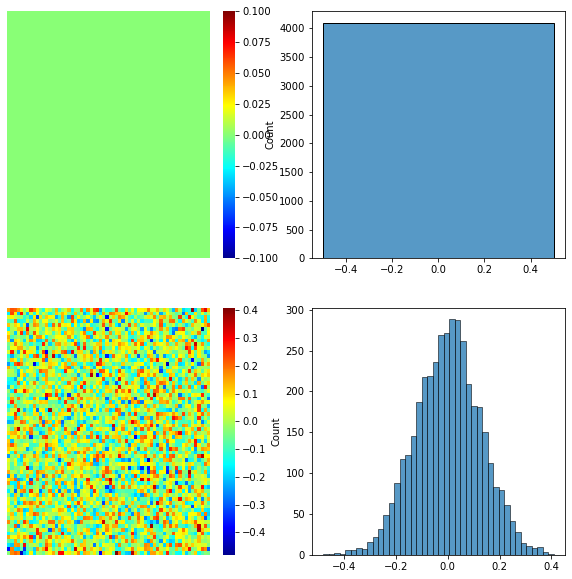

In [47]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

_, cm = ulmo_plotting.load_palette()

old = sns.heatmap(img0, xticklabels = [], yticklabels = [], ax = axes[0,0], cmap =cm)
a = sns.histplot(img0.flatten(), stat = 'count', ax = axes[0,1], legend = False)
new = sns.heatmap(img1, xticklabels = [], yticklabels = [], ax = axes[1,0], cmap =cm)
a = sns.histplot(img1.flatten(), stat = 'count', ax = axes[1,1], legend = False)

In [48]:
print('For the original image, Mean is: {} and std dev is: {}'.format(np.mean(img0), np.std(img0)))
print('For the new image,      Mean is: {} and std dev is: {}'.format(np.mean(img1), np.std(img1)))

For the original image, Mean is: 0.0 and std dev is: 0.0
For the new image,      Mean is: 0.0007261017894422926 and std dev is: 0.12676537042979485


In [49]:
print('The mean temp was: {} and the std of noise dist is {}'.format(tmp, std))

The mean temp was: 20 and the std of noise dist is 0.127


# Zonal Temperature Gradient Cutout

In [50]:
img0 = np.empty( shape=(64, 64) )
for i in range(64):
    img0[:, i] = 0.001*(i+1) -0.032

tmp = 20 
std = 0.031 + 0.0048*tmp

noise = np.random.normal(0., std, (64,64))

img1 = img0 + noise

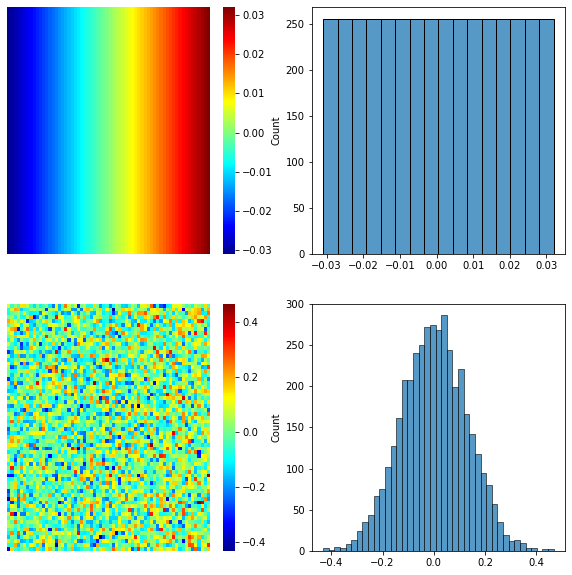

In [51]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

_, cm = ulmo_plotting.load_palette()

old = sns.heatmap(img0, xticklabels = [], yticklabels = [], ax = axes[0,0], cmap =cm)
a = sns.histplot(img0.flatten(), stat = 'count', ax = axes[0,1], legend = False)
new = sns.heatmap(img1, xticklabels = [], yticklabels = [], ax = axes[1,0], cmap =cm)
a = sns.histplot(img1.flatten(), stat = 'count', ax = axes[1,1], legend = False)

In [52]:
mean0 = np.mean(img0)
mean1 = np.mean(img1)

sig0 = np.std(img0)
sig1 = np.std(img1)

print('For the original image, Mean is: {} and std dev is: {}'.format(mean0, sig0))
print('For the new image,      Mean is: {} and std dev is: {}'.format(mean1, sig1))

For the original image, Mean is: 0.0004999999999999999 and std dev is: 0.018472953201911165
For the new image,      Mean is: 0.001118538952911726 and std dev is: 0.12898979317347062


In [53]:
print('sigma_diff: {}'.format(sig1-sig0))
print('mean_diff: {}'.format(mean1-mean0))

sigma_diff: 0.11051683997155945
mean_diff: 0.0006185389529117261


# Task 1: Differences between 100 cutouts

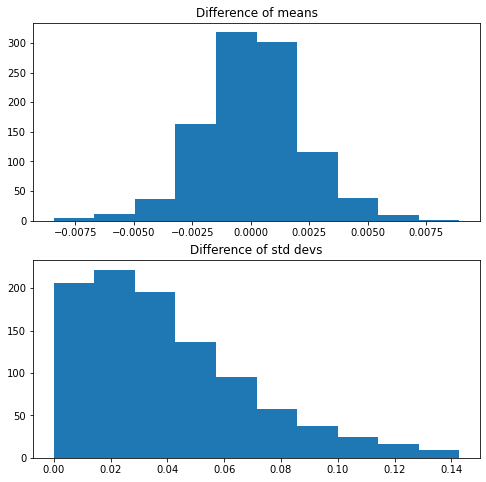

In [54]:
run task1.py

In [55]:
mean1

1.2665987e-07

In [56]:
mean2

-0.00039855484

In [57]:
mean1 - mean2

0.0003986815

In [58]:
print('Maximum: {} and Minimum: {}'.format(np.max(mean_d), np.min(mean_d)))

Maximum: 0.008920004591345787 and Minimum: -0.008422262966632843


In [135]:
sig1

0.17789535

In [136]:
sig2

0.22752868

In [138]:
sig2-sig1

0.049633324

In [139]:
print('Maximum: {} and Minimum: {}'.format(np.max(sigma_d), np.min(sigma_d)))

Maximum: 0.149572491645813 and Minimum: 0.0007619857788085938


In [140]:
idx

376560

In [142]:
with h5py.File( 'LLC_modis2012_test_preproc.h5', 'r') as f: 
    mean_T= f['valid_metadata'][idx,7]
    tmp = float( mean_T.decode() )
    print( 0.031 + 0.0048*tmp)

0.13752687072753905


In [129]:
run task2.py

Read main table: s3://llc/Tables/test_modis2012.parquet
s3://llc/ThetaUVSalt/LLC4320_2012-04-10T00_00_00.nc


In [203]:
d = np.array([0, 0.1, 0.2, 0.2, -0.1])
np.mean(d)

0.08

In [204]:
e = np.ones(5)
f = d + e
np.mean(f)

1.08

In [206]:
g = 10*np.ones(5)
h = d + g
np.mean(h)

10.08